# 神经网络的学习

## 损失函数

### 均方误差

$E = \frac{1}{2} \sum_{k} (y_k - t_k)^2$

这里，$y_k$表示神经网络的输出，$t_k$表示监督数据，$k$表示数据的维度

In [1]:
# 均方误差
import numpy as np

def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t)**2)

y1 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

#损失函数值越小越准确
print(mean_squared_error(np.array(y1),np.array(t)))
print(mean_squared_error(np.array(y2),np.array(t)))

0.09750000000000003
0.5975


### 交叉熵误差

$E = - \sum_{k} t_k \log{y_k}$

这里，$log$表示以$e$为底数的自然对数，$y_k$是神经网络的输出，$t_k$是正确的标签解，并且$t_k$中只有正确解的标签索引为1，其他均为0（one-hot表示）

In [2]:
#交叉熵误差
import numpy as np

def cross_entropy_error(y, t):
    delta = 1e-7
    #加入 delta，避免出现log(0)  -inf
    return -np.sum(t * np.log(y + delta))

y1 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

print(cross_entropy_error(np.array(y1),np.array(t)))
print(cross_entropy_error(np.array(y2),np.array(t)))

0.510825457099338
2.302584092994546


In [3]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:

    def __init__(self):
        self.W = np.random.randn(2,3) #用高斯分布进行初始化

    def pridect(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.pridect(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t) #交叉熵误差
        return loss
    
x = np.array([0.6, 0.9]) #输入数据
t = np.array([0, 0, 1]) #测试数据

net = simpleNet()
p = net.pridect(x)
print("权重参数:",net.W)
print("预测数据",p)
print("最大值的索引",np.argmax(p))
print("交叉熵误差",net.loss(x, t))

f = lambda w: net.loss(x, t) #定义新函数是可以使用lamda表达式
dW = numerical_gradient(f, net.W)

print("梯度",dW)

权重参数: [[-0.98255164  0.74214025  0.02237858]
 [ 1.34330735  0.58419891  1.03176256]]
预测数据 [0.61944563 0.97106318 0.94201345]
最大值的索引 1
交叉熵误差 1.0129679182545093
梯度 [[ 0.15781025  0.22430594 -0.38211619]
 [ 0.23671538  0.33645891 -0.57317428]]


# 学习算法的实现

## 前提

神经网络存在合适的权重和偏置，调整权重和偏置以便拟合训练数据的过程称为`学习`。神经网络的学习分成下面四个步骤

## 步骤1（mini-batch）

从训练数据中随机选取一部分数据，这部分数据称为`mini-batch`。我们的目标是减小mini-batch的损失函数的值

## 步骤2（计算梯度）

为了减小mini-batch的损失函数的值，需要求各个权重参数的梯度。梯度表示损失函数的值减小最多的方向

## 步骤3（更新参数）

将权重参数沿梯度方向进行微小更新。

## 步骤4（重复）

重复步骤1、步骤2、步骤3

In [4]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
from common.functions import *
from common.gradient import numerical_gradient
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

class TwoLayerNet:

    # 进行初始化
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        #生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    # 进行识别（推理）
    def predict(self, x):
        for layer in self.layers.values():
            x= layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    # 计算识别精度
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: 
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # 通过数值微分计算关于权重参数的梯度
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    # 通过误差反向传播法计算关于权重参数的梯度
    def gradient(self, x, t):
        #forward
        self.loss(x, t)

        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        #倒序
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)


        #设定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
    
        return grads

train acc, test acc | 0.15718333333333334, 0.1567
train acc, test acc | 0.9051333333333333, 0.9073
train acc, test acc | 0.9229333333333334, 0.9247
train acc, test acc | 0.93665, 0.937
train acc, test acc | 0.9458833333333333, 0.9442
train acc, test acc | 0.953, 0.9516
train acc, test acc | 0.9581333333333333, 0.9533
train acc, test acc | 0.9594666666666667, 0.9574
train acc, test acc | 0.9637, 0.9601
train acc, test acc | 0.96705, 0.9623
train acc, test acc | 0.9704833333333334, 0.9649
train acc, test acc | 0.9710166666666666, 0.9634
train acc, test acc | 0.9732666666666666, 0.9686
train acc, test acc | 0.9750166666666666, 0.9682
train acc, test acc | 0.97495, 0.9692
train acc, test acc | 0.9764666666666667, 0.97
train acc, test acc | 0.9777833333333333, 0.969


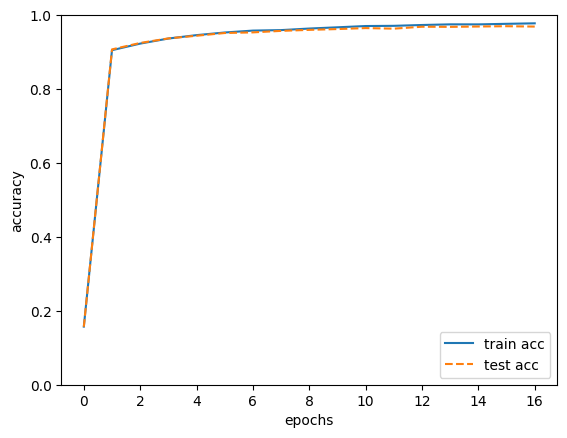

In [4]:


# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 适当设定循环的次数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 计算梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()